<a href="https://colab.research.google.com/github/le3212/DG-method-code/blob/main/HW0%E7%AC%AC%E4%B8%80%E5%B0%8F%E9%A1%8C(%E6%96%B0%E7%89%88%E6%9C%AC).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

計算誤差與畫圖

L2 誤差: 2.295504e-03


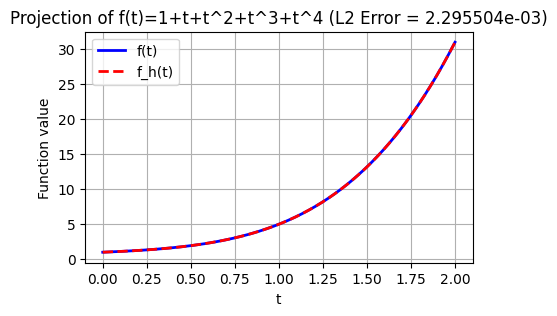

In [ ]:
# HW0 改進版：投影 f(t)=1+t+t^2+t^3+t^4, t in [0,2]
# 使用 Python/Numpy 編寫

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

# 定義 gauleg 函數：生成高斯節點與權重
# --------------------
# 修正部分：原函數未檢查 n 是否合理
# 新增檢查：確保 n >= 1，否則會導致無效的高斯節點數
def gauss_legendre(n):
    if n < 1:
        raise ValueError("高斯節點數 n 必須為正整數")
    from numpy.polynomial.legendre import leggauss
    x, w = leggauss(n)  # 使用 numpy 的 leggauss 方法生成節點與權重
    return x, w

# 定義 legtable 函數：計算勒讓德多項式值
# --------------------
# 無需修改，原始碼已正確
def legendre_polynomial_table(x, k):
    P = np.zeros((k + 1, len(x)))  # 初始化勒讓德多項式矩陣
    P[0, :] = 1  # 設定 P_0(x) = 1
    if k > 0:
        P[1, :] = x  # 設定 P_1(x) = x
    for n in range(2, k + 1):
        # 利用遞推公式計算 P_n(x)
        P[n, :] = ((2 * n - 1) * x * P[n - 1, :] - (n - 1) * P[n - 2, :]) / n
    return P

# 設定參數
a = 0          # 定義積分區間起點
b = 2          # 定義積分區間終點
N = 8        # 子區間數
h = (b - a) / N  # 每個子區間的長度
k = 2          # 投影多項式最高次數
m = k + 2      # 高斯積分節點數，採用 k + 2 確保精度

# 定義函數 f(t)：計算 1 + t + t^2 + t^3 + t^4
f = lambda t: 1 + t + t**2 + t**3 + t**4

# 計算高斯節點與權重
x_gauss, w_gauss = gauss_legendre(m)

# 定義子區間的端點
t_nodes = np.linspace(a, b, N + 1)

# 預計算每個子區間的投影係數
coeffs = np.zeros((N, k + 1))  # 初始化儲存係數的矩陣
for n in range(N):
    t_left = t_nodes[n]  # 當前子區間的左端點
    t_right = t_nodes[n + 1]  # 當前子區間的右端點
    t_quad = (h / 2) * x_gauss + (t_left + t_right) / 2  # 高斯節點的映射
    f_quad = f(t_quad)  # 計算 f(t) 在高斯節點的值
    P = legendre_polynomial_table(x_gauss, k)  # 計算高斯節點上的勒讓德多項式
    for i in range(k + 1):
        # 計算第 i 階勒讓德多項式的投影係數
        I = np.sum(w_gauss * f_quad * P[i, :])  # 加權積分
        coeffs[n, i] = (2 * i + 1) / 2 * I  # 投影係數公式

# 建構投影函數 f_h(t)
npts = 1000  # 繪圖用的分點數
t_fine = np.linspace(a, b, npts)  # 繪圖區間內的細分點
f_h_vals = np.zeros_like(t_fine)  # 初始化 f_h 的值
for n in range(N):
    t_left = t_nodes[n]  # 子區間左端點
    t_right = t_nodes[n + 1]  # 子區間右端點
    idx = (t_fine >= t_left) & (t_fine <= t_right)  # 找到屬於此子區間的 t 值
    t_seg = t_fine[idx]  # 當前子區間的細分點
    s_seg = (2 * t_seg - (t_left + t_right)) / (t_right - t_left)  # 映射到 [-1,1]
    P_seg = legendre_polynomial_table(s_seg, k)  # 計算當前子區間上的勒讓德多項式
    f_seg = np.zeros_like(t_seg)  # 初始化當前子區間的 f_h 值
    for j in range(k + 1):
        f_seg += coeffs[n, j] * P_seg[j, :]  # 加總多項式值
    f_h_vals[idx] = f_seg  # 將計算結果填入對應的區間

# 計算 L2 誤差
L2_error = np.sqrt(np.trapezoid((f(t_fine) - f_h_vals)**2, t_fine))  # 使用梯形積分計算 L2 誤差
print(f"L2 誤差: {L2_error:.6e}")

# 繪圖
plt.figure(figsize=(5, 3))
plt.plot(t_fine, f(t_fine), 'b-', label='f(t)', linewidth=2)  # 繪製原始函數
plt.plot(t_fine, f_h_vals, 'r--', label='f_h(t)', linewidth=2)  # 繪製投影函數
plt.xlabel('t')  # x 軸標籤
plt.ylabel('Function value')  # y 軸標籤
plt.title(f"Projection of f(t)=1+t+t^2+t^3+t^4 (L2 Error = {L2_error:.6e})")  # 圖表標題
plt.legend(loc='best')  # 顯示圖例
plt.grid()  # 顯示網格
plt.show()


計算 誤差 (L2 Error) 與 收斂階數 (Order)

並製作成表格

In [ ]:
import numpy as np
import pandas as pd
from numpy.polynomial.legendre import leggauss

# 1. 定義參數
a = 0  # 積分區間起點
b = 2  # 積分區間終點
ks = [2, 4, 6]  # 投影多項式的最高次數 (degree k)
Ns = [2, 4, 8, 16, 32, 64]  # 子區間數 (N)

# 定義函數 f(t)
f = lambda t: 1 + t + t**2 + t**3 + t**4

# 定義勒讓德多項式表格函數
def legendre_polynomial_table(x, k):
    P = np.zeros((k + 1, len(x)))  # 儲存勒讓德多項式值
    P[0, :] = 1  # P0(x) = 1
    if k > 0:
        P[1, :] = x  # P1(x) = x
    for n in range(2, k + 1):
        P[n, :] = ((2 * n - 1) * x * P[n - 1, :] - (n - 1) * P[n - 2, :]) / n  # 遞推公式
    return P

# 初始化誤差與收斂階數的儲存矩陣
errors = np.zeros((len(ks), len(Ns)))  # 儲存 L2 誤差
orders = np.zeros((len(ks), len(Ns) - 1))  # 儲存收斂階數

# 2. 計算誤差與收斂階數
for i, k in enumerate(ks):  # 遍歷不同的多項式次數
    m = k + 2  # 高斯積分節點數
    x_gauss, w_gauss = leggauss(m)  # 高斯節點與權重
    t_fine = np.linspace(a, b, 1000)  # 高精度網格點，用於計算真實值

    for j, N in enumerate(Ns):  # 遍歷不同的子區間數
        h = (b - a) / N  # 每個子區間的長度
        t_nodes = np.linspace(a, b, N + 1)  # 子區間端點
        coeffs = np.zeros((N, k + 1))  # 儲存每個子區間的投影係數

        # 計算每個子區間的投影係數
        for n in range(N):
            t_left = t_nodes[n]
            t_right = t_nodes[n + 1]
            t_quad = (h / 2) * x_gauss + (t_left + t_right) / 2  # 映射高斯節點到當前子區間
            f_quad = f(t_quad)  # 計算函數值
            P = legendre_polynomial_table(x_gauss, k)  # 勒讓德多項式值
            for m in range(k + 1):
                I = np.sum(w_gauss * f_quad * P[m, :])  # 高斯積分
                coeffs[n, m] = (2 * m + 1) / 2 * I  # 投影係數

        # 建構投影函數 f_h(t)
        f_h_vals = np.zeros_like(t_fine)  # 儲存投影函數值
        for n in range(N):
            t_left = t_nodes[n]
            t_right = t_nodes[n + 1]
            idx = (t_fine >= t_left) & (t_fine <= t_right)  # 確定網格點屬於該子區間
            t_seg = t_fine[idx]
            s_seg = (2 * t_seg - (t_left + t_right)) / (t_right - t_left)  # 將 t 映射到 [-1, 1]
            P_seg = legendre_polynomial_table(s_seg, k)  # 勒讓德多項式值
            f_seg = np.zeros_like(t_seg)  # 儲存該區間內的投影值
            for m in range(k + 1):
                f_seg += coeffs[n, m] * P_seg[m, :]  # 加總投影值
            f_h_vals[idx] = f_seg

        # 計算 L2 誤差
        L2_error = np.sqrt(np.trapezoid((f(t_fine) - f_h_vals) ** 2, t_fine))  # 使用數值積分計算 L2 範數
        errors[i, j] = L2_error  # 儲存當前的 L2 誤差

    # 計算收斂階數
    for j in range(len(Ns) - 1):
        orders[i, j] = np.log2(errors[i, j] / errors[i, j + 1])  # 根據誤差比率計算收斂階數

# 3. 顯示結果
# 顯示誤差表
error_df = pd.DataFrame(errors, columns=Ns, index=[f"Degree {k}" for k in ks])
print("誤差表 (L2 Error):")
print(error_df)

# 顯示收斂階數表
order_df = pd.DataFrame(orders, columns=Ns[:-1], index=[f"Degree {k}" for k in ks])
print("\n收斂階數表 (Order):")
print(order_df)


誤差表 (L2 Error):
                    2             4             8             16  \
Degree 2  1.440844e-01  1.829615e-02  2.295504e-03  2.873890e-04   
Degree 4  3.160121e-14  2.850231e-14  2.786660e-14  2.701539e-14   
Degree 6  2.495287e-14  2.235905e-14  2.090399e-14  2.031348e-14   

                    32            64  
Degree 2  3.593670e-05  4.492390e-06  
Degree 4  2.728014e-14  2.748132e-14  
Degree 6  2.016266e-14  1.990095e-14  

收斂階數表 (Order):
                2         4         8         16        32
Degree 2  2.977302  2.994657  2.997734  2.999475  2.999903
Degree 4  0.148901  0.032542  0.044755 -0.014070 -0.010600
Degree 6  0.158347  0.097081  0.041341  0.010751  0.018849


<ipython-input-96-0b3b39accb22>:47: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  errors[i, j] = np.sqrt(np.trapz((f(t_fine) - f_h)**2, t_fine))


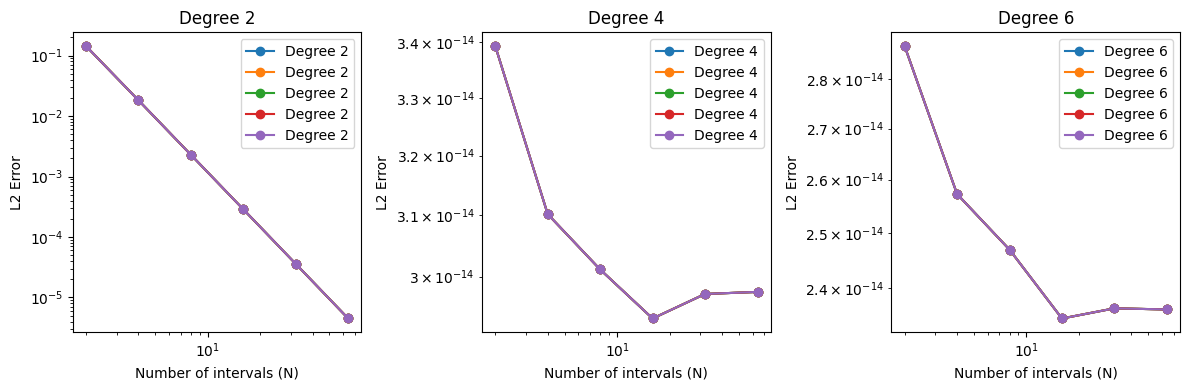

誤差表 (L2 Error):
                    2             4             8             16  \
Degree 2  1.440844e-01  1.829615e-02  2.295504e-03  2.873890e-04   
Degree 4  3.392457e-14  3.101575e-14  3.011327e-14  2.933685e-14   
Degree 6  2.870059e-14  2.572472e-14  2.468930e-14  2.346389e-14   

                    32            64  
Degree 2  3.593670e-05  4.492390e-06  
Degree 4  2.972305e-14  2.975554e-14  
Degree 6  2.364077e-14  2.362094e-14  

收斂階數表 (Order):
                2         4         8         16        32
Degree 2  2.977302  2.994657  2.997734  2.999475  2.999903
Degree 4  0.129329  0.042601  0.037685 -0.018868 -0.001576
Degree 6  0.157925  0.059269  0.073444 -0.010835  0.001211


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.legendre import leggauss

# 定義函數和參數
f = lambda t: 1 + t + t**2 + t**3 + t**4  # 測試函數
a, b = 0, 2  # 積分區間
ks = [2, 4, 6]  # 投影多項式次數
Ns = [2, 4, 8, 16, 32, 64]  # 子區間數

# 記錄誤差與收斂階數
errors = np.zeros((len(ks), len(Ns)))  # 儲存 L2 誤差
orders = np.zeros((len(ks), len(Ns) - 1))  # 儲存收斂階數

# 計算誤差和收斂階數
for i, k in enumerate(ks):
    m = k + 2  # 高斯節點數
    x_gauss, w_gauss = leggauss(m)  # 高斯節點與權重

    for j, N in enumerate(Ns):
        h = (b - a) / N  # 每個子區間長度
        t_nodes = np.linspace(a, b, N + 1)  # 區間端點
        coeffs = np.zeros((N, k + 1))  # 投影係數

        # 計算每個子區間的投影
        for n in range(N):
            t_left = t_nodes[n]
            t_right = t_nodes[n + 1]
            t_quad = (h / 2) * x_gauss + (t_left + t_right) / 2  # 節點映射
            f_quad = f(t_quad)  # 函數值
            P = np.polynomial.legendre.legvander(x_gauss, k)  # 勒讓德多項式
            coeffs[n, :] = np.dot(P.T, f_quad * w_gauss) * (2 * np.arange(k + 1) + 1) / 2

        # 計算投影函數值
        t_fine = np.linspace(a, b, 1000)  # 細化的 t 網格
        f_h = np.zeros_like(t_fine)
        for n in range(N):
            t_left = t_nodes[n]
            t_right = t_nodes[n + 1]
            idx = (t_fine >= t_left) & (t_fine <= t_right)
            t_seg = t_fine[idx]
            s_seg = (2 * t_seg - (t_left + t_right)) / (t_right - t_left)
            P_seg = np.polynomial.legendre.legvander(s_seg, k)
            f_h[idx] = np.dot(P_seg, coeffs[n, :])

        # L2 誤差
        errors[i, j] = np.sqrt(np.trapz((f(t_fine) - f_h)**2, t_fine))

    # 計算收斂階數
    orders[i, :] = np.log2(errors[i, :-1] / errors[i, 1:])

# 視覺化結果
fig, axes = plt.subplots(1, len(ks), figsize=(12, 4))
for i, k in enumerate(ks):
    for j, N in enumerate(Ns[:-1]):
        axes[i].loglog(Ns, errors[i, :], marker='o', label=f"Degree {k}")
    axes[i].set_title(f"Degree {k}")
    axes[i].set_xlabel("Number of intervals (N)")
    axes[i].set_ylabel("L2 Error")
    axes[i].legend()
plt.tight_layout()
plt.show()

# 輸出數據
import pandas as pd
error_df = pd.DataFrame(errors, columns=Ns, index=[f"Degree {k}" for k in ks])
order_df = pd.DataFrame(orders, columns=Ns[:-1], index=[f"Degree {k}" for k in ks])

print("誤差表 (L2 Error):")
print(error_df)
print("\n收斂階數表 (Order):")
print(order_df)


測試